In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import folium
from selenium import webdriver
from selenium.webdriver import FirefoxOptions
import time

In [2]:
df = pd.read_csv('ems_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715641 entries, 0 to 715640
Data columns (total 6 columns):
Unnamed: 0                        715641 non-null int64
Original Call for Service Type    715641 non-null object
Final Call for Service Type       715641 non-null object
Incident Date                     715641 non-null object
ZIP Code                          715641 non-null int64
Aldermanic District               715641 non-null int64
dtypes: int64(3), object(3)
memory usage: 32.8+ MB


In [3]:
df['Incident Date'] = pd.to_datetime(df['Incident Date'])

In [4]:
year_data = df['Incident Date'].dt.year.value_counts()
for index in year_data.index:
    print(str(index)+':', year_data[index], end = '\r\n')

2018: 127850
2016: 118605
2017: 118381
2019: 117714
2015: 116042
2020: 89981
2021: 27068


<BarContainer object of 7 artists>

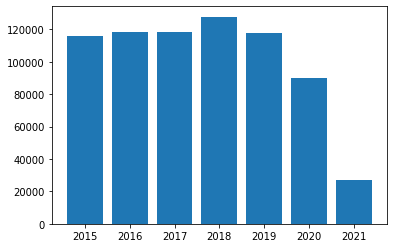

In [5]:
plot_data = df['Incident Date'].dt.year.value_counts()
fig, ax = plt.subplots()
ax.bar(plot_data.index, plot_data)

In [16]:
mismatch = df[df['Original Call for Service Type'] != df['Final Call for Service Type']]
# mismatch[mismatch['Original Call for Service Type'] == 'Unknown Problem (Man Down)']
mismatch[mismatch['Original Call for Service Type'] == 'Sick Person (Specific Diagnosis)']['Final Call for Service Type'].value_counts()

MTB1                                                   1320
Downgraded Response                                    1113
MED Unit Special Call                                  1057
MTB2                                                    846
CTB1                                                    601
Paratech Turnback 3                                     547
PTB1                                                    396
Paratech Turnback 1                                     317
PTB3                                                    286
Paratech Turnback 4                                     277
PTB2                                                    208
Curtis Turnback 1                                       130
Curtis Turnback 3                                       111
Medacare Turnback 2                                      83
Curtis Turnback 2                                        73
Unknown Problem (Man Down)                               70
Medacare Turnback 1                     

In [7]:
df['ZIP Code'].unique()

array([53206,     0, 53210, 53233, 53209, 53215, 53216, 53202, 53224,
       53225, 53212, 53207, 53223, 53219, 53218, 53221, 53227, 53222,
       53204, 53205, 53208, 53211, 53203, 53220, 53226, 53228, 53214,
       53154, 53213, 53172, 53217, 53051, 53110, 53132, 53130, 53129])

In [8]:
with open('wi_wisconsin_zip_codes_geo.min.json', 'r') as jsonFile:
    data = json.load(jsonFile)
tmp = data

geozips = []
for i in range(len(tmp['features'])):
    if tmp['features'][i]['properties']['ZCTA5CE10'] in str(list(df['ZIP Code'].unique())):
        geozips.append(tmp['features'][i])
        
for geozip in geozips:
    geozip['properties']['ZCTA5CE10'] = int(geozip['properties']['ZCTA5CE10'])

new_json = dict.fromkeys(['type', 'features'])
new_json['type'] = 'FeatureCollection'
new_json['features'] = geozips

new_file = open('MKE-zips.json', 'w')
new_file.write(
    json.dumps(new_json, sort_keys = True, indent = 4, separators = (',', ': '))
)
new_file.close()



In [9]:
def create_map(feature, value, add_text = ''):
    table = generate_map_df(feature, value)
    mke_geo = r'MKE-zips.json'
    m = folium.Map(location = [43.0389, -87.9065], zoom_start = 10)
    # creating a choropleth map
    m.choropleth(
        geo_data = mke_geo,
        fill_opacity = 0.7,
        line_opacity = 0.2,
        data = table,
        # refers to which key within the GeoJSON to map the ZIP code to
        key_on = 'properties.ZCTA5CE10',
        # first element contains location information, second element contains feature of interest
        columns = ['ZIP Code', feature],
        fill_color = 'RdYlGn_r',
        legend_name = feature + ' = ' + value
    )
    folium.LayerControl().add_to(m)
    # save map with filename based on the feature of interest
    return m

In [17]:
def get_counts(zip_code, feature, value):
    zips = df[df['ZIP Code'] == zip_code]
    zips_feature = zips[zips[feature] == value]
    return len(zips_feature)

In [18]:
def generate_map_df(feature, value):
    map_df = pd.DataFrame({'ZIP Code': df['ZIP Code'].unique()})
    map_df[feature] = map_df['ZIP Code'].apply(lambda x: get_counts(x, feature, value))
    map_df = map_df[map_df['ZIP Code'] != 0]
    return map_df

In [11]:
def save_map(m, name):
    opts = FirefoxOptions()
    opts.add_argument("--headless")
#     browser = webdriver.Firefox(firefox_options=opts)
    m.save('map.html')
    driver = webdriver.Firefox(executable_path=r'./geckodriver', firefox_options=opts)
    driver.set_window_size(500, 500)  # choose a resolution
    driver.get('file:///home/ad.msoe.edu/clavela/CS3310/map.html')
    time.sleep(5)
    driver.save_screenshot('./map_images/' + name.replace('/', '_') + '.png')

In [20]:
for feature in ['Original Call for Service Type']:
    for value in df[feature].value_counts().head(20).index:
        m = create_map(feature, value)
        save_map(m, feature + '=' + value)
        print('Finished:', feature + '=' + value + '.png')

/home/ad.msoe.edu/clavela/.local/lib/python3.7/site-packages/folium/folium.py:413: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: use options instead of firefox_options
  


Finished: Original Call for Service Type=Sick Person (Specific Diagnosis).png
Finished: Original Call for Service Type=Breathing Problems.png
Finished: Original Call for Service Type=Unknown Problem (Man Down).png
Finished: Original Call for Service Type=Falls.png
Finished: Original Call for Service Type=Traffic/Transportation Accidents.png
Finished: Original Call for Service Type=Chest Pain (Non-Traumatic).png
Finished: Original Call for Service Type=Assault/Sexual Assault.png
Finished: Original Call for Service Type=ALARM.png
Finished: Original Call for Service Type=Unconscious/Fainting (Near).png
Finished: Original Call for Service Type=Convulsions/Seizures.png
Finished: Original Call for Service Type=Private Ambulance.png
Finished: Original Call for Service Type=Diabetic Problems.png
Finished: Original Call for Service Type=Hemorrhage/Lacerations.png
Finished: Original Call for Service Type=Abdominal Pain/Problems.png
Finished: Original Call for Service Type=Traumatic Injuries (Spe